Current scan (W7-X on-site)
===========================

This example shows how to use an on-axis current as a perturbation to scan toroidal current effects. As the target device, we use the Wendelstein 7-X Stellarator.

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x

Note: The W7-X geometry is currently protected by the W7-X data access agreement. Therefore, the file referenced below is available to W7-X team members (including external collaborators who signed this agreement) upon request.

In [2]:
fsc.resolve.importOfflineData('../../w7x-op21.fsc')

Now we need to setup the geometry and magnetic field configuration.

In [3]:
field = w7x.standard()
geometry = w7x.op21Geometry()

# Let's slim down our grid a bit so we calculate faster
grid = w7x.defaultGrid()
grid.nPhi = 32

field = field.compute(grid)
geometry = geometry.index(w7x.defaultGeometryGrid())

We evaluate our Poincare plot in the plane of the Multi-Purpose manipulator (which is at 200.8 deg)

In [4]:
import numpy as np
phiPlanes = np.radians([200.8])

# Put more starting points inside the island
rStart = np.concatenate([
    np.linspace(4.5, 4.8, 10, endpoint = False),
    np.linspace(4.8, 5.4, 10)
])
phiStart = np.linspace(0, 2 * np.pi, 5, endpoint = False) + np.pi

# Starting on an r, phi grid allows us to see all 5 islands
rStartG, phiStartG = np.meshgrid(rStart, phiStart, indexing = 'ij')

xStart = rStartG * np.cos(phiStartG)
yStart = rStartG * np.sin(phiStartG)
zStart = 0 * rStartG

startPoints = [xStart, yStart, zStart]

Now it's time to run our calculations. Note that on W7-X, currents are defined to be positive when running in the clock-wise direction. We use the helpers from the W7-X module to handle the conventions.

Note: There are two functions to perform axis-current computations, the `fsc.flt.axisCurrent` and the `fsc.devices.w7x.axisCurrent` function. They take exactly the same arguments, but `fsc.flt.axisCurrent` has default behavior tailored towards generic devices, while `fsc.devices.w7x.axisCurrent` has default parameters more suited for Wendelstein 7-X calculations (current direction, default grid, starting points).

In [ ]:
currents = [2500, 5000, 10000]

def fieldWithCurrent(current):
    return field + w7x.axisCurrent(field, current)

pcPoints = {
    current : fsc.flt.poincareInPhiPlanes(
        startPoints, fieldWithCurrent(current), phiPlanes, 200,
        grid = grid,
        geometry = geometry,
        distanceLimit = 1e4,
        targetError = 1e-4
    )
    
    for current in currents
}

The calculation returns a numpy array with a specific shape:
- The first dimension of the array is always 5. The first 3 entries are the x, y, z positions of the intersection points, while the other 2 are forward and backward connection-lengths. Negative values indicate, that the respective length (given by the absolute value) is given by something other than a collision event (start point, tracing limit, leaving the grid, etc.)
- The second dimension corresponds to the selected phi values to do the intersection at.
- The third dimension on corresponds to the dimensions of the starting point array (excluding its first xyz dimension)
- Finally, the last dimension corresponds to the turn counter of the field line.

We can now plot each series of intersection points. For this, we can also make use of the fsc.geometry.plotCut function, which will compute phi slices of the geometry.

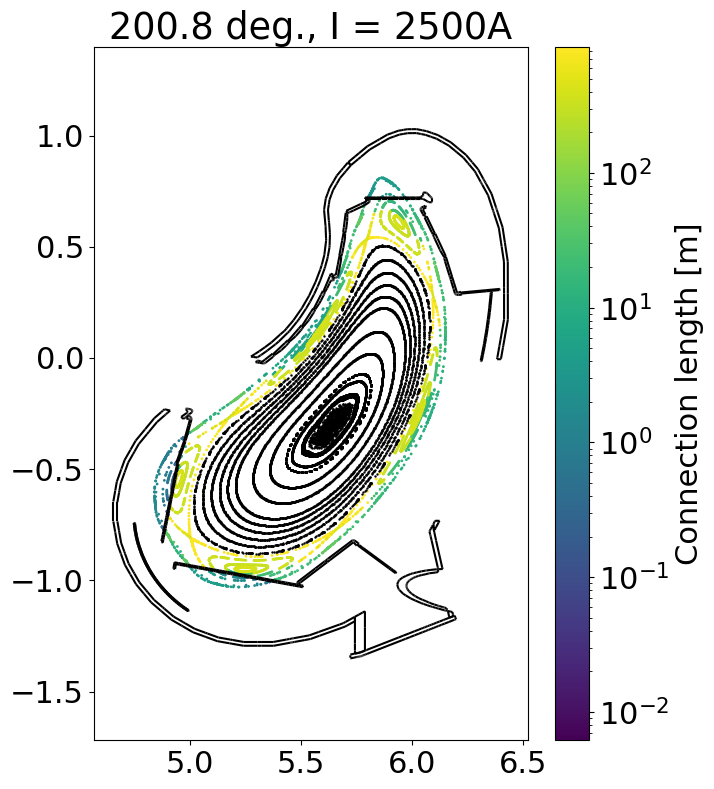

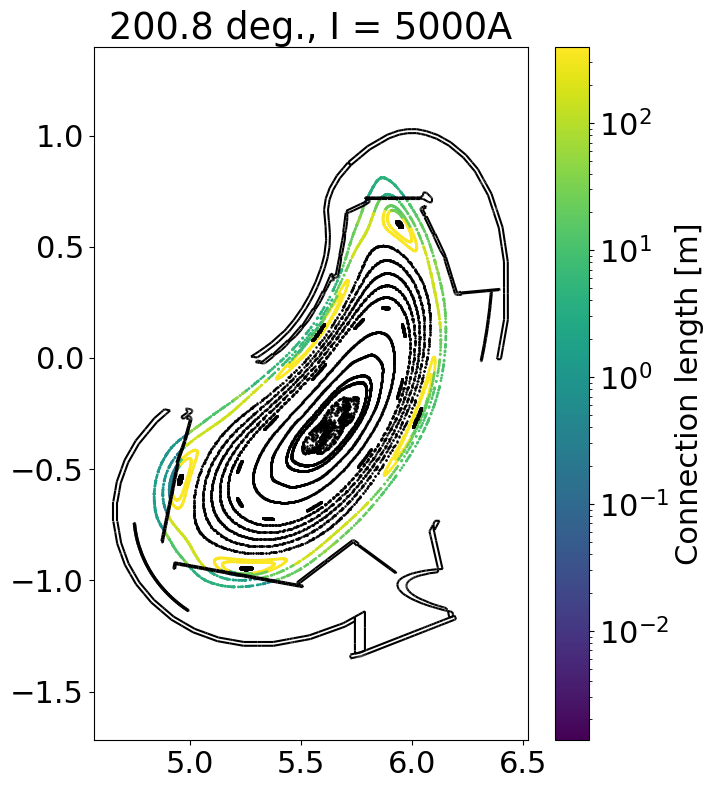

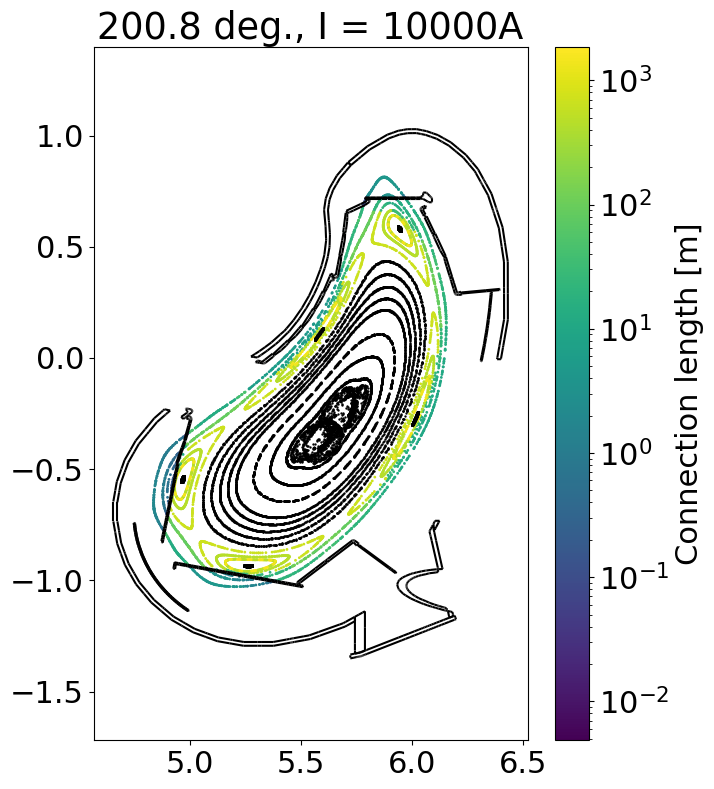

In [7]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 22})

for iPhi, phi in enumerate(phiPlanes):
    for current, pcp in pcPoints.items():
        x, y, z, cLenF, cLenB = pcp[:, iPhi, :, :].reshape([5, -1])
        r = np.sqrt(x**2 + y**2)

        # Negative connection lengths indicate that the line segment going through
        # the point in that direction is not terminated by collision (e.g. it left
        # the grid or hit the distance limit)
        mask = np.logical_and(cLenF > 0, cLenB > 0)
        mask2 = np.logical_and(cLenF < 0, cLenB < 0)

        cLen = cLenF + cLenB

        plt.figure(figsize = (7, 9))
        plt.title(str(np.degrees(phi)) + ' deg., I = ' + str(current) + 'A')
        plt.scatter(r[mask], z[mask], c = cLen[mask], norm = matplotlib.colors.LogNorm(), s = 1)
        plt.colorbar(label = 'Connection length [m]')
        plt.scatter(r[mask2], z[mask2], c = 'k', s = 0.5)

        geometry.plotCut(phi, edgecolors = 'k')
        plt.axis('equal')